<h1> Steps Involved as </h1>

1. Input an image.
2. Make sure an image has less than 2.2 aspect ratio. Otherwise divide it into half whichever is larger (width or height)
3. Perform SelectiveSearchAlgorithm and take 2k region only.
4. Extract each proposal region into 4096 feature extraction using AlexNet.
5. Classify the object by SVM model.
6. Predict the BB by rigde regression. (Make sure coordinates are in [x,y,w,h] (NOT [x1,y1,x2,y2])

In [1]:
import numpy as np # For numerical computation
import cv2 # For reading an image and perform selective search algorithm
import matplotlib.pyplot as plt # To plot the image
import tensorflow as tf # To load alexnet model and predict 4096 feature extraction
import tqdm # To display progress bar
from joblib import load # To load SVM and regression model from sklearn

In [57]:
# 1. Input an Image
imgFile = 'test_img4.jpg'
img = cv2.imread(imgFile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. Make sure an image has less than 2.2 aspect ratio
h,w,_ = img.shape
# print(img.shape)

if h > w and h/w > 2.2:
    img = cv2.resize(img, (w,h//2))
elif h < w and w/h > 2.2:
    img = cv2.resize(img, (w//2,h))

In [58]:
# 3. Perform selective search algorithm
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
result_ss = ss.process()

# Keep duplicate image to save check point (to restore read an image rather than going to read again)
img_dup = img.copy()

# Take 2k region
test_X = []
test_BB = []

for i in range(result_ss.shape[0]):
    if i > 2000:
        break
    
    x1,y1,w,h = result_ss[i]
    
    ts_img = img[y1:y1+h, x1:x1+w]
    ts_resize = cv2.resize(ts_img, (227,227), cv2.INTER_AREA)
    ts_resize = ts_resize.astype('float32')
    ts_resize = ts_resize/255
    test_X.append(ts_resize)
    test_BB.append([x1,y1,w,h])
    
test_X = np.array(test_X)
test_BB = np.array(test_BB)

In [59]:
# 4. Extract 4096 feature extraction using Alexnet
# Load architecture from json file
json_file = open('alexnet_arch.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# Load save weights
loaded_model.load_weights("alexnet_weights.hdf5")

# Create another instantiate for removing last layer.
model = tf.keras.models.Model(loaded_model.input,loaded_model.layers[-2].output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327

In [60]:
test_feat = []
for i in tqdm.tqdm_notebook(range(test_X.shape[0])):
    test_feat.append(list(model.predict(np.expand_dims(test_X[i], axis=0))[0]))
test_feat = np.array(test_feat)

C:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [61]:
# 5. Classify object for eack 2k region

# There are label values
# {'bicycle': 0,
#  'bus': 1,
#  'car': 2,
#  'cat': 3,
#  'cow': 4,
#  'dog': 5,
#  'horse': 6,
#  'motorbike': 7,
#  'person': 8,
#  'sheep': 9,
#  'background': 10}

# These are the labels we did trained for
label = ['bicycle','bus','car','cat','cow','dog','horse','motorbike','person','sheep','background']
label_dict = dict()

for i,j in enumerate(label):
    label_dict[j] = i
label_dict

# Load the trained svm model
load_svm_model = load('Classify_object.pkl')

# Store prediction (as label) as well as prediction in probabilities
test_pred = load_svm_model.predict(test_feat)
test_pred_proba = load_svm_model.predict_proba(test_feat)

In [62]:
# Display some value
np.unique(test_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

In [63]:
# Predict BB

# Exactly written same as per above image
def pred_BB(P, dP):
    '''
    Return Predicted BB value
    
    Parameters:
    P: Proposal BB in coordinates [x,y,w,h]
    df: Predicted value by regression model. [x,y,w,h]
    '''
    
    G_x = P[2]*dP[0] + P[0]
    G_y = P[3]*dP[1] + P[1]
    G_w = P[2]*np.exp(dP[2])
    G_h = P[3]*np.exp(dP[3])
    
    return [G_x,G_y,G_w,G_h]

# Get the label name from the given prediction
def get_label(pred_val):
    for k,v in label_dict.items():
        if v == pred_val:
            return k

In [64]:
# Load the regression model to predict BB
load_reg_model = load('BB_regression.pkl')

# This is like a 'dP' value in equation if you remember
pred_val = load_reg_model.predict(test_BB)

# Calculate predict BB
test_predBB = []
for i in range(test_BB.shape[0]):
    test_predBB.append(pred_BB(test_BB[i],pred_val[i]))

In [65]:
# Display some value
test_predBB[:5]

[[61.02693073089255, 153.83416893803386, 14.12955964613273, 9.210181239248758],
 [80.26233261030424, 163.8248809721556, 88.35377533359761, 9.243664078185514],
 [232.81653221738372,
  12.004769442426538,
  16.16609161962234,
  15.137848074660306],
 [75.00873675591134,
  138.61338440846612,
  14.137352045622395,
  24.50377703021713],
 [218.63381299206048,
  0.06415643637784202,
  34.28115597560786,
  30.204774927214434]]

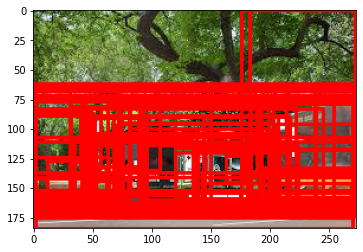

In [66]:
# Display the BB in an image
for i in range(test_X.shape[0]):
    if test_pred[i] != 10:
        x,y,w,h = test_predBB[i]
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        imgBB = cv2.rectangle(img, (x,y),(x+w,y+h), (255, 0, 0), 2)

plt.imshow(imgBB)

Multiple BB are generating over a single object One of the method which can reduce is by using `Non Max Suprression`.

<img src='img/nnms.png' >

In [67]:
def get_IOU(bb1,bb2):
    '''
    Calculate IOU of two bounding box
    
    Parameters:
    bb1: First bounding box in dict() format which contain 4 coordinates with labelled as 'x1','y1','x2','y2'
    bb2: Second bounding box in dict() format which contain 4 coordinates with labelled as 'x1','y1','x2','y2'
    
    Return:
    IOU value
    '''
    # Make sure in both Bounding boxes coordinates are valid
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    # Finding intersection
    x_left = max(bb1['x1'],bb2['x1'])
    y_bottom = max(bb1['y1'],bb2['y1'])
    x_right = min(bb1['x2'],bb2['x2'])
    y_top = min(bb1['y2'],bb2['y2'])
    
    # Checking whether there is any intersection avaiable
    # If not, return area of intersection as 0.
    if (x_left > x_right) or (y_bottom > y_top):
        return 0.0
    # Otheriwise
    area_intersect = (x_right - x_left) * (y_top - y_bottom)
    
    # To bring into percentage, calculate area of each bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    # p(AUB) = p(A) + p(B) - p(A,B)
    total_area = bb1_area + bb2_area - area_intersect
    # Finally in percentage
    iou = area_intersect / total_area
    
    # Make sure, IOU values within 0 to 1
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

def nnms(B, c, pred_label, overlap=0.5):
    '''
    Non-max suppression method
    
    Parameters:
    B: list of proposal bounding box contain [x,y,w,h] list format
    c: corresponding corresponding score
    overlap: Minimum overlap threshold value between two bounding box 
    pred_label: List of predict label value
    
    Return:
    list of filtered proposal D and their label value
    '''
    # List of filtered proposal D
    D = []    
    # List of filtered label
    D_predlabel = []
    D_index =-1
    
    # Iterate over until list of proposal bounding box get empty    
    while len(B):
        # Find proposal BB which have high confidence score
        max_c = 0
        # Iterate over confidence score
        for i in range(len(c)):
            # If found max confidence score
            # get the corresponding index value
            if max_c < c[i]:
                max_c = c[i]
                max_index = i
                
        # Store BB into D which have highest confidence score we just got corresponding index
        D.append(B[max_index])
        D_predlabel.append(pred_label[max_index])
        D_index += 1
        
        # Delete from the list B and also there corresponding confidence score and label
        B = np.delete(B,max_index,axis=0)
        c = np.delete(c,max_index)
        pred_label = np.delete(pred_label,max_index)
        
        # Compare 'D' with all the BB which present in list B
        # Create a dict() of 'D' informat ['x1','y1','x2','y2']
        # Because get_IOU() function take two input parameters as dict.
        # You can see the docstring of get_IOU() function
        Dx1 = D[D_index][0]
        Dy1 = D[D_index][1]
        Dx2 = Dx1 + D[D_index][2]
        Dy2 = Dy1 + D[D_index][3]
        D_BB = {'x1': Dx1,'y1':Dy1,'x2':Dx2,'y2':Dy2}
        
        # Create a variable which store the index value that has to be
        # deleted after finding 'D' with every 'B' proposal region
        del_index = []
        for i in range(len(B)):
            Bx1 = B[i][0]
            By1 = B[i][1]
            Bx2 = Bx1 + B[i][2]
            By2 = By1 + B[i][3]
            # Create a dict() of 'B' informat ['x1','y1','x2','y2']
            B_BB = {'x1': Bx1,'y1':By1,'x2':Bx2,'y2':By2}
            # If area between 'D' with other list of proposal in 'B' greater
            # than overlap value then reject from the list of that proposal in 'B'
            if get_IOU(D_BB, B_BB) > overlap:
                del_index.append(i)

        # Now update the new 'B' and their corresponding confidence score 'c'
        B = np.delete(B,del_index,axis=0)
        c = np.delete(c,del_index)
        pred_label = np.delete(pred_label,del_index)
        
    return np.array(D), np.array(D_predlabel)

In [68]:
# List of index that correspondes to class label 10 (which is 'background' label)
index_10 = []
for i in range(len(test_BB)):
    if test_pred[i] == 10:
        index_10.append(i)

In [69]:
# Remove or create another variable which contain only objects (not background label)
# List of BB
ts_predBB = []
# list of confidence score
confidence_score = []
# List od predict label
ts_predlabel = []

# Store those only where label contain object (not background)
for i in range(len(test_pred)):
    if i not in index_10:
        ts_predBB.append(test_predBB[i])
        confidence_score.append(np.max(test_pred_proba[i]))
        ts_predlabel.append(test_pred[i])
        
# Convert into numpy
ts_predBB = np.array(ts_predBB)
confidence_score = np.array(confidence_score)
ts_predlabel = np.array(ts_predlabel)

In [70]:
# Check the dims of these variables
ts_predBB.shape, confidence_score.shape, ts_predlabel.shape

((139, 4), (139,), (139,))

In [71]:
# Run the Non max suppression method
result, result_label = nnms(ts_predBB,confidence_score,ts_predlabel,0.00001)

In [72]:
# Display the dims of resultant
result.shape, result_label.shape

((4, 4), (4,))

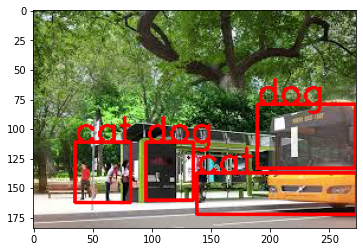

In [73]:
# Display the result BB in an image and corresponding label
img = img_dup.copy()
for i in range(result.shape[0]):
    x,y,w,h = result[i]
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    imgBB = cv2.rectangle(img, (x,y),(x+w,y+h), (255, 0, 0), 2)
    cv2.putText(imgBB, get_label(result_label[i]),(x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

plt.imshow(imgBB)